Dataset description:


The training archive contains 25,000 images of dogs and cats. Train your algorithm on these files and predict the labels for test1.zip (1 = dog, 0 = cat).



1. Explore the Example Data of Cats and Dogs
2. Build a Convolutional Neural Network
3. Data Preprocessing
4. Training
5. Visualizing Intermediate Representations (Optional)
6. Making predictions
7. Evaluate the Training and Validation accuracy

In [ ]:
import tensorflow as tf
import keras
import matplotlib.pyplot as plt
import tensorflow_datasets as tfds
import cv2
from tensorflow.keras.models import Sequential,Model
from tensorflow.keras.layers import Conv2D,Dropout,Dense, Flatten, MaxPooling2D, GlobalAveragePooling2D
from tensorflow.keras.utils import plot_model

# Read the data and pre-process

,image,label
0,,1 (dog)
1,,0 (cat)
2,,0 (cat)
3,,1 (dog)

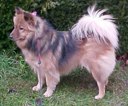
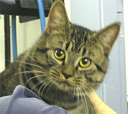
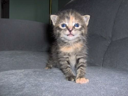
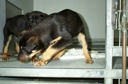

In [ ]:
train_data,info= tfds.load('cats_vs_dogs', split='train[:80%]', as_supervised=True, shuffle_files=True, with_info=True)
validation_data = tfds.load('cats_vs_dogs', split = 'train[80%:90%]', as_supervised = True)
test_data = tfds.load('cats_vs_dogs', split = 'train[-10%:]', as_supervised = True)
tfds.as_dataframe(train_data.take(4),info)

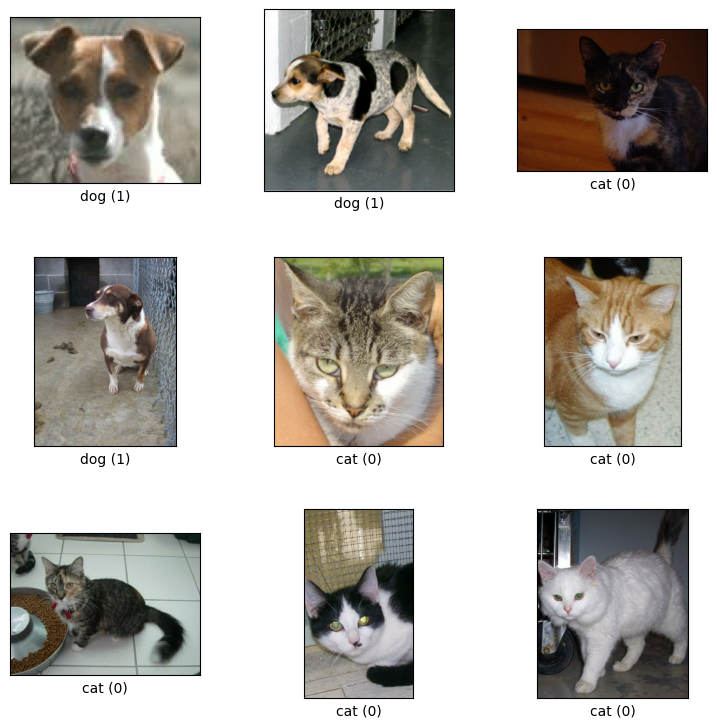

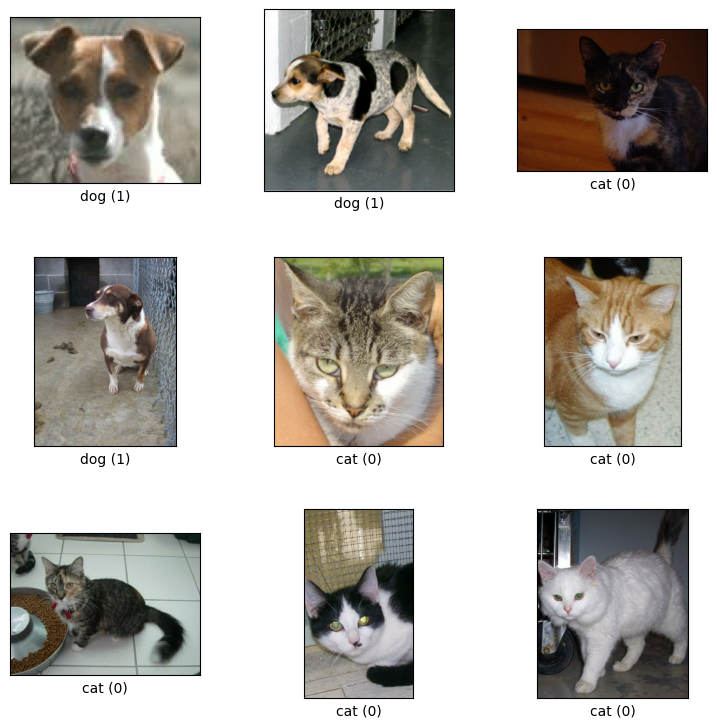

In [ ]:
tfds.show_examples(train_data, info)

Methods of tfds.load()

split=: Which split to read (e.g. 'train', ['train', 'test'], 'train[80%:]',...)

shuffle_files=: Control whether to shuffle the files between each epoch.

data_dir=: Location where the dataset is saved ( defaults to ~/
tensorflow_datasets/)

with_info=True: Returns the tfds.core.DatasetInfo containing dataset metadata

download=False: Disable download

as_supervised=True, you can get a tuple (features, label) instead for supervised datasets.

Load with with_info=True

Let’s check what info we get when we set with_info=True when we load our datasets. It gives the details about the dataset

In [ ]:
print(info.features['label'].num_classes)
print(info.features['label'].names)


2
['cat', 'dog']


In [ ]:
print(info.features['image'].shape)
print(info.features['image'].dtype)

(None, None, 3)
<dtype: 'uint8'>


In [ ]:
info.splits

{'train': <SplitInfo num_examples=23262, num_shards=16>}

In [ ]:
# check the shape of images
i = 0
for img, label in train_data:
  print(f'Image shape: {img.shape}\t Label: {label.numpy()}')  # tensor.numpy() gives the value of the tensor
  i += 1
  if i == 5:
    break

Image shape: (100, 114, 3)	 Label: 1
Image shape: (420, 440, 3)	 Label: 1
Image shape: (490, 500, 3)	 Label: 0
Image shape: (332, 500, 3)	 Label: 1
Image shape: (411, 408, 3)	 Label: 1


The cell below will preprocess the images and create batches before feeding it into the model

In [ ]:
def preprocess_images(image, label):
  # cast to float
  image = tf.cast(image, tf.float32)
  # normalize the pixel values
  image = (image / 255)
  # resize to 300 x 300
  image = tf.image.resize(image, (30, 30))
  return image, label

# use the utility function above to preprocess the images
processed_training_data = train_data.map(preprocess_images)

# shuffle and create batches before training
train_batches = processed_training_data.shuffle(1024).batch(32)

In [ ]:
# preprocess validation data set
validation_processed = validation_data.map(preprocess_images)
validation_batches = validation_processed.shuffle(1024).batch(32)

In [ ]:
# Check the training dataset after creating batches of data
for img_batch, label_batch in train_batches:
  print(f'Shape of image batch: {img_batch.shape}\t Shape of label batch: {label_batch.shape}')
  break

Shape of image batch: (32, 30, 30, 3)	 Shape of label batch: (32,)


# Model builing

In [ ]:
model= Sequential()
model.add(Conv2D(16, input_shape=(30,30,3), kernel_size=(3,3),activation='relu', padding='same'))
model.add(MaxPooling2D(pool_size=(2,2)))

model.add(Conv2D(32, kernel_size=(3,3),activation='relu', padding='same'))
model.add(MaxPooling2D(pool_size=(2,2)))

model.add(Conv2D(64, kernel_size=(3,3),activation='relu', padding='same'))
model.add(MaxPooling2D(pool_size=(2,2)))

model.add(Conv2D(128, kernel_size=(3,3),activation='relu', padding='same'))
model.add(GlobalAveragePooling2D(name='gpool'))

model.add(Dense(1, activation='softmax'))
model.summary()

Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_28 (Conv2D)          (None, 30, 30, 16)        448       
                                                                 
 max_pooling2d_21 (MaxPooli  (None, 15, 15, 16)        0         
 ng2D)                                                           
                                                                 
 conv2d_29 (Conv2D)          (None, 15, 15, 32)        4640      
                                                                 
 max_pooling2d_22 (MaxPooli  (None, 7, 7, 32)          0         
 ng2D)                                                           
                                                                 
 conv2d_30 (Conv2D)          (None, 7, 7, 64)          18496     
                                                                 
 max_pooling2d_23 (MaxPooli  (None, 3, 3, 64)         

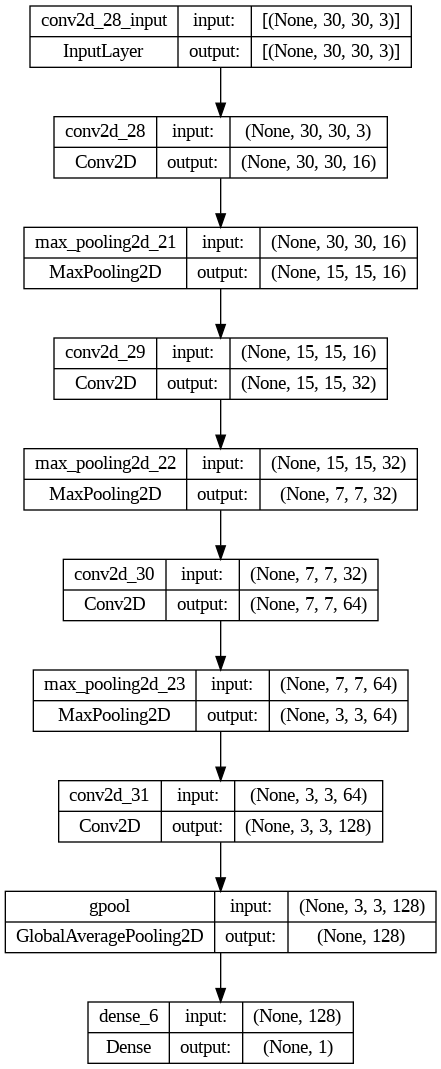

In [ ]:
### plot model
plot_model(model, show_shapes = True, dpi = 96)

In [ ]:
# Model using functional API  (same model as above)
inputs = tf.keras.layers.Input(shape = (300, 300, 3), name = 'input_layer')

x = Conv2D(16, kernel_size = (3, 3), activation = 'relu', padding = 'same')(inputs)
x = MaxPooling2D(pool_size = (2, 2))(x)

x = Conv2D(32, kernel_size = (3, 3), activation = 'relu', padding = 'same')(x)
x = MaxPooling2D(pool_size = (2, 2))(x)

x = Conv2D(filters = 64, kernel_size =(3, 3), activation = 'relu', padding = 'same')(x)
x = MaxPooling2D(pool_size = (2, 2))(x)

x = Conv2D(128, (3, 3), activation = 'relu', padding = 'same')(x)  # filters and kernel_size keywords are omitted
x = GlobalAveragePooling2D(name = 'gpool')(x)
output = Dense(1, activation = 'sigmoid')(x)

model_func = Model(inputs = inputs, outputs = output, name = 'Functional_Model')

model_func.summary()

Model: "Functional_Model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_layer (InputLayer)    [(None, 300, 300, 3)]     0         
                                                                 
 conv2d_32 (Conv2D)          (None, 300, 300, 16)      448       
                                                                 
 max_pooling2d_24 (MaxPooli  (None, 150, 150, 16)      0         
 ng2D)                                                           
                                                                 
 conv2d_33 (Conv2D)          (None, 150, 150, 32)      4640      
                                                                 
 max_pooling2d_25 (MaxPooli  (None, 75, 75, 32)        0         
 ng2D)                                                           
                                                                 
 conv2d_34 (Conv2D)          (None, 75, 75, 64)   

# Compile & fit the model

In [ ]:
model.compile(loss='binary_crossentropy',
              optimizer= 'Adam',
              metrics= ['Accuracy'])


model.fit(train_batches,
          batch_size=32,
          validation_data=validation_batches,
          epochs=5
          )



Epoch 1/5
582/582 [==============================] - 62s 101ms/step - loss: 0.6666 - Accuracy: 0.4961 - val_loss: 0.6337 - val_Accuracy: 0.5185
Epoch 2/5
582/582 [==============================] - 54s 90ms/step - loss: 0.6041 - Accuracy: 0.4961 - val_loss: 0.5779 - val_Accuracy: 0.5185
Epoch 3/5
582/582 [==============================] - 59s 99ms/step - loss: 0.5577 - Accuracy: 0.4961 - val_loss: 0.5456 - val_Accuracy: 0.5185
Epoch 4/5
582/582 [==============================] - 53s 87ms/step - loss: 0.5164 - Accuracy: 0.4961 - val_loss: 0.5152 - val_Accuracy: 0.5185
Epoch 5/5
582/582 [==============================] - 54s 90ms/step - loss: 0.4702 - Accuracy: 0.4961 - val_loss: 0.4886 - val_Accuracy: 0.5185


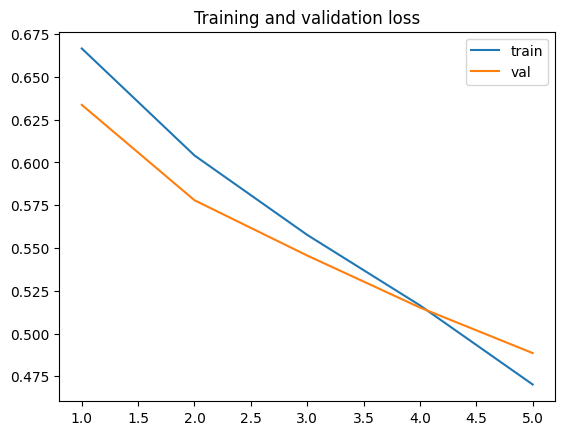

In [ ]:
# plot loss and accuracy curves on training and validation data
plt.plot(range(1, 6), model.history.history['loss'],)
plt.plot(range(1, 6), model.history.history['val_loss'])
plt.legend(['train', 'val'])
plt.title('Training and validation loss');

In [ ]:
# utility function to preprocess an image and show the CAM
def convert_and_classify(image):

  # load the image
  img = cv2.imread(image)

  # preprocess the image before feeding it to the model
  img = cv2.resize(img, (128, 128)) / 255.0

  # add a batch dimension because the model expects it
  tensor_image = np.expand_dims(img, axis = 0)

  # get the features and prediction
  features, results = cam_model.predict(tensor_image)

  # generate the CAM
  show_cam(tensor_image, features, results)

convert_and_classify('cat1.jpg')
convert_and_classify('cat2.jpg')
convert_and_classify('catanddog.jpg')
convert_and_classify('dog1.jpg')
convert_and_classify('dog2.jpg')


error: OpenCV(4.8.0) /io/opencv/modules/imgproc/src/resize.cpp:4062: error: (-215:Assertion failed) !ssize.empty() in function 'resize'
